In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from mc2.data_management import EXPERIMENT_LOGS_ROOT,MODEL_DUMP_ROOT
from mc2.models.model_interface import ModelInterface, NODEwInterface, RNNwInterface, JAwInterface, JAParamMLPwInterface, JAWithGRUwInterface, JAWithExternGRUwInterface,load_model, GRUWithJAwInterface
from mc2.models.jiles_atherton import JAStatic, JAStatic2, JAParamGRUlin, JAParamMLP,JAWithExternGRU,JAWithGRU,JAWithGRUlin, GRUWithJA
from mc2.models.RNN import GRU
import jax
import equinox as eqx
import json
import pathlib
from typing import Type
from mc2.models.model_interface import ModelInterface
from mc2.runners.model_setup_jax import get_normalizer
import jax.numpy as jnp
from mc2.data_management import EXPERIMENT_LOGS_ROOT, NORMALIZATION_ROOT, load_hdf5_pretest_data

In [4]:
exp_id = "f57e0626"
seed = 1
def load_preds_n_gt(exp_id, seed):
    fp = EXPERIMENT_LOGS_ROOT / f"exp_{exp_id}_seed_{seed}_preds_transformed.parquet"
    fp2 = EXPERIMENT_LOGS_ROOT / f"exp_{exp_id}_seed_{seed}_gt_transformed.parquet"
    fp3 = EXPERIMENT_LOGS_ROOT / f"exp_{exp_id}_seed_{seed}_preds_untransformed.parquet"
    fp4 = EXPERIMENT_LOGS_ROOT / f"exp_{exp_id}_seed_{seed}_gt.parquet"
    preds_transformed_MS = pd.read_parquet(fp).to_numpy()
    preds_untransformed_MS = pd.read_parquet(fp3).to_numpy()
    gt_transformed_MS = pd.read_parquet(fp2).to_numpy()
    gt_MS = pd.read_parquet(fp4).to_numpy()
    return gt_MS, gt_transformed_MS, preds_transformed_MS, preds_untransformed_MS


In [5]:
def plot_worst_predictions3(exp_id, seed, freq_idx, metric="MSE"):
    gt_MS,pred_MS = load_preds_n_gt2(exp_id, seed, freq_idx)
    
    mae_M = np.mean(np.abs(gt_MS - pred_MS), axis=-1)
    mse_M = np.mean((gt_MS - pred_MS)**2, axis=-1)
    rmse_M = np.sqrt(np.mean((gt_MS - pred_MS)**2, axis=-1))/np.sqrt(np.mean(gt_MS**2, axis=-1))
    if metric=="RMSE":
        sorted_idx = np.argsort(rmse_M)[::-1]
    elif metric=="MAE":
        sorted_idx = np.argsort(mae_M)[::-1]
    else:   
        sorted_idx = np.argsort(mse_M)[::-1]
    worst_idx=sorted_idx[:5]
    
    print(f"MAE {mae_M.mean():.1f} A/m | MSE {mse_M.mean():.1f} (A/m)² | RMSE {rmse_M.mean():.3f}")

    fig, axes = plt.subplots(5, 1 , sharex=True, sharey="col", figsize=(10, 15))
    axes[0].set_title(f"Worst {metric}")
    for i,idx in enumerate(worst_idx):
        ax = axes[i]
        ax.plot(gt_MS[idx], label='gt')
        ax.plot(pred_MS[idx], label='pred', ls='dashed')
        ax.annotate(f"MAE {mae_M[idx]:.1f} A/m | "
                    f"MSE {mse_M[idx]:.1f} (A/m)² | RMSE {rmse_M[idx]:.3f}", 
                    (0.3, 0.1), xycoords=ax.transAxes)
            
    axes.flatten()[0].legend()
    for ax in axes.flatten():
        ax.grid(alpha=0.3)
    for ax in axes:
        ax.set_ylabel("H in A/m")
    for ax in [axes[-1]]:
        ax.set_xlabel("Sequence step")

    fig.tight_layout()

In [6]:

def plot_first_predictions(exp_key, show_normalized_pred=False):
    gt_MS, gt_transformed_MS, preds_transformed_MS, preds_untransformed_MS = load_preds_n_gt(**experiments_d[exp_key])
    fig, axes = plt.subplots(5, 1 + int(show_normalized_pred), sharex=True, sharey="col", figsize=(10, 15))
    mae_M = np.mean(np.abs(gt_MS - preds_untransformed_MS), axis=-1)
    mse_M = np.mean((gt_MS - preds_untransformed_MS)**2, axis=-1)
    print(f"MAE {mae_M.mean():.1f} A/m | MSE {mse_M.mean():.1f} (A/m)²")
    for tst_idx in range(axes.shape[0]):
        if show_normalized_pred:
            ax = axes[tst_idx, 0]
        else:
            ax = axes[tst_idx]
        ax.plot(gt_MS[tst_idx], label='gt')
        ax.plot(preds_untransformed_MS[tst_idx], label='pred', ls='dashed')
        ax.annotate(f"MAE {mae_M[tst_idx]:.1f} A/m | "
                    f"MSE {mse_M[tst_idx]:.1f} (A/m)²",
                    (0.3, 0.1), xycoords=ax.transAxes)
        if show_normalized_pred:
            axes[tst_idx, 1].plot(gt_transformed_MS[tst_idx])
            axes[tst_idx, 1].plot(preds_transformed_MS[tst_idx], ls='dashed')
            
    axes.flatten()[0].legend()
    for ax in axes.flatten():
        ax.grid(alpha=0.3)
    for ax in axes[:, 0] if show_normalized_pred else axes:
        ax.set_ylabel("H in A/m")
    if show_normalized_pred:
        for ax in axes[:, 1]:
            ax.set_ylabel("H normalized")
    for ax in axes[-1, :] if show_normalized_pred else [axes[-1]]:
        ax.set_xlabel("Sequence step")
    fig.tight_layout()


In [7]:
def load_preds_n_gt2(exp_id, seed, freq_idx):
    gt = EXPERIMENT_LOGS_ROOT / f"{exp_id}/seed_{seed}_seq_{freq_idx}_gt.parquet"
    pred = EXPERIMENT_LOGS_ROOT / f"{exp_id}/seed_{seed}_seq_{freq_idx}_preds.parquet"
    gt_MS = pd.read_parquet(gt).to_numpy()
    pred_MS = pd.read_parquet(pred).to_numpy()
    return gt_MS, pred_MS

In [8]:
def freq_test_mse_mae(exp_id, seed):
    mses=[]
    maes=[]
    for idx in range(7):
        gt = EXPERIMENT_LOGS_ROOT / f"{exp_id}/seed_{seed}_seq_{idx}_gt.parquet"
        pred = EXPERIMENT_LOGS_ROOT / f"{exp_id}/seed_{seed}_seq_{idx}_preds.parquet"
        gt_MS = pd.read_parquet(gt).to_numpy()
        pred_MS = pd.read_parquet(pred).to_numpy()
        mse_M = np.mean((gt_MS - pred_MS)**2)
        mae_M = np.mean(np.abs(gt_MS - pred_MS))
        mses.append(mse_M)
        maes.append(mae_M)
    return mses,maes

In [9]:
def plot_first_predictions2(exp_id, seed, freq_idx):
    gt_MS,pred_MS = load_preds_n_gt2(exp_id, seed, freq_idx)
    fig, axes = plt.subplots(5, 1 , sharex=True, sharey="col", figsize=(10, 15))
    mae_M = np.mean(np.abs(gt_MS - pred_MS), axis=-1)
    mse_M = np.mean((gt_MS - pred_MS)**2, axis=-1)
    print(f"MAE {mae_M.mean():.1f} A/m | MSE {mse_M.mean():.1f} (A/m)²")
    for tst_idx in range(axes.shape[0]):
        ax = axes[tst_idx]
        ax.plot(gt_MS[tst_idx], label='gt')
        ax.plot(pred_MS[tst_idx], label='pred', ls='dashed')
        ax.annotate(f"MAE {mae_M[tst_idx]:.1f} A/m | "
                    f"MSE {mse_M[tst_idx]:.1f} (A/m)²",
                    (0.3, 0.1), xycoords=ax.transAxes)
            
    axes.flatten()[0].legend()
    for ax in axes.flatten():
        ax.grid(alpha=0.3)
    for ax in axes:
        ax.set_ylabel("H in A/m")
    for ax in [axes[-1]]:
        ax.set_xlabel("Sequence step")
    fig.tight_layout()

In [10]:
def plot_worst_predictions2(exp_id, seed, freq_idx):
    gt_MS,pred_MS = load_preds_n_gt2(exp_id, seed, freq_idx)
    
    mae_M = np.mean(np.abs(gt_MS - pred_MS), axis=-1)
    mse_M = np.mean((gt_MS - pred_MS)**2, axis=-1)
    sorted_idx = np.argsort(mse_M)[::-1]
    worst_mse=sorted_idx[:5]
    sorted_idx = np.argsort(mae_M)[::-1]
    worst_mae=sorted_idx[:5]
    print(f"MAE {mae_M.mean():.1f} A/m | MSE {mse_M.mean():.1f} (A/m)²")

    for metric in ["MSE","MAE"]:
        worst_idx = worst_mse if metric=="MSE" else worst_mae
        fig, axes = plt.subplots(5, 1 , sharex=True, sharey="col", figsize=(10, 15))
        axes[0].set_title(f"Worst {metric}")
        for i,idx in enumerate(worst_idx):
            ax = axes[i]
            ax.plot(gt_MS[idx], label='gt')
            ax.plot(pred_MS[idx], label='pred', ls='dashed')
            ax.annotate(f"MAE {mae_M[idx]:.1f} A/m | "
                        f"MSE {mse_M[idx]:.1f} (A/m)²",
                        (0.3, 0.1), xycoords=ax.transAxes)
                
        axes.flatten()[0].legend()
        for ax in axes.flatten():
            ax.grid(alpha=0.3)
        for ax in axes:
            ax.set_ylabel("H in A/m")
        for ax in [axes[-1]]:
            ax.set_xlabel("Sequence step")

        fig.tight_layout()

In [11]:
def freq_test_mse_rmse(exp_id, seed):
    mses=[]
    rmse=[]
    for idx in range(7):
        gt = EXPERIMENT_LOGS_ROOT / f"{exp_id}/seed_{seed}_seq_{idx}_gt.parquet"
        pred = EXPERIMENT_LOGS_ROOT / f"{exp_id}/seed_{seed}_seq_{idx}_preds.parquet"
        gt_MS = pd.read_parquet(gt).to_numpy()
        pred_MS = pd.read_parquet(pred).to_numpy()
        mse_per_sequence_M = np.mean((pred_MS - gt_MS) ** 2, axis=1)
        mse_M = np.mean(mse_per_sequence_M)
        sre_per_sequence = np.sqrt(mse_per_sequence_M) / np.sqrt(np.mean(gt_MS**2, axis=1))
        rmse_M = np.mean(sre_per_sequence)
        mses.append(mse_M)
        rmse.append(rmse_M)
    return mses,rmse

In [12]:

#exp_id = "3C90_b908af2d-7a65-41"# (GRU8-500-new2)
#exp_id = "3C90_4ec8f810-298b-49"# (JA-150-new2)
#exp_id = "3C90_cf80a118-8ef2-45" #(JAGRU-500-new2)
#exp_id = "3C90_9cc48d20-9b06-45" # (JA_with_GRU-500-new2)
#exp_id = "3C90_e769bd50-d7ab-4f" # (JAGRU-500-new2-inf)
#exp_id = "3C90_524bba60-0d7e-47" # (JA_with_GRU-500-new2)
#exp_id = "3C90_17dc6665-fa81-45" # (JAParamGRUlin-500)
#exp_id = "3C90_3be24d39-018c-4d" # (JAWithGRUlin)
#exp_id = "3C90_54f92af8-ef9e-4c"# (JAWithGRU-500-new2)
#exp_id = "3C90_af7dbb52-ecab-4b"#"3C90_68d6facc-9e57-4b"#"3C90_35cbeab0-b592-46" #(JAWithExternGRU-500-new2)
#exp_id = "3C90_42e00d3a-8639-48" #  (JAWithGRUlinFinal-750-new2)
#exp_id = "3C90_50ef802d-7ccc-4c" # (JAWithGRUlin-750-new2)
#exp_id = "3C90_588a856c-2134-49" # (JAParamMLP-500)
# exp_id = "3C90_1519b7ac-ef06-4c" # (JAParamGRUlin-500)
# seed = 0


In [13]:
seed = 0
#exp_id = "3C90_8c804f77"#"3C90_78f120d2"
#exp_id ="3C90_7632996d-4c4c-40"#(RMS-GRU8)#"3C90_4d5b2cc1-4e08-46"#"3C90_5cf07234-fbc2-44" #(RMS-JA+GRu 10epoche) # ##(MSE-GRU8)#
exp_id_ja = "3C90_4ec8f810-298b-49"# (JA-150-new2)
#exp_id = "3C90_0a78ff01-c96b-4d" #(JA-WITH-GRU8-100)
exp_id_gru_64 = "3C90_374086cf-c35e-44"#(GRU- 1000 -t 64)
exp_id_gru_128 = "3C90_3518af4e-4e09-42"#(GRU- 1000 -t 128)"3C90_e872d115-8497-4e"#(GRU- 500 -t 128) #"3C90_b908af2d-7a65-41" 
exp_id_gru_128_l2 = "3C90_bb0ba4f2-3c5d-42" # (GRU -100 -t 128 loss2)
exp_id_gru_256 = "3C90_ff01bbb9-9cbf-44"#(GRU- 2000 -t 256)#"3C90_2df43a32-dd32-4b"#(GRU- 750 -t 256)
exp_id_gru_512 = "3C90_058d5c98-bf0b-4c"#(GRU- 750 -t 512)
#exp_id_ja_w_ext_gru = "3C90_524bba60-0d7e-47" # (JAWithExternGRU-500-new2)
exp_id_ja_w_ext_gru = "3C90_af7dbb52-ecab-4b"#"3C90_68d6facc-9e57-4b"#"3C90_35cbeab0-b592-46" #(JAWithExternGRU-500-new2)
#exp_id_ja_w_gru = "3C90_3be24d39-018c-4d" # (JAWithGRUlin)
exp_id_ja_w_gru_lin = "3C90_50ef802d-7ccc-4c" # (JAWithGRUlin-750-new2)
exp_id_param_mlp = "3C90_77b93f91-6624-45"#(JAParamMLP-750 -t 64) #"3C90_588a856c-2134-49"
exp_id_param_gru_lin = "3C90_50565649-6028-44" #(JaParamGRUlin-500 -t 128)#"3C90_1519b7ac-ef06-4c" # (JAParamGRUlin-500)
exp_id_ja_w_gru = "3C90_54f92af8-ef9e-4c"# (JAWithGRU-500-new2)
exp_id_gru_ja = "3C90_cb66532d-ee29-4e" #(GRUWithJA -1000 -t 128)

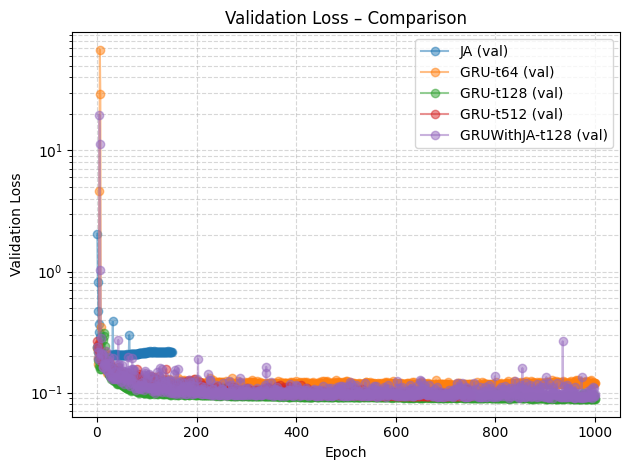

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

seed = 0

# Aktive Experimente
exp_ids = {
    "JA": exp_id_ja,
    "GRU-t64":exp_id_gru_64,
    "GRU-t128": exp_id_gru_128,
    #"GRU-t256": exp_id_gru_256,
    "GRU-t512": exp_id_gru_512,
    "GRUWithJA-t128":exp_id_gru_ja
    # "JAWithExternGRU": exp_id_ja_w_ext_gru,
    # "JaWithGRU": exp_id_ja_w_gru,
    # "JAWithGRUlin": exp_id_ja_w_gru_lin,
    # "JAParamMLP": exp_id_param_mlp,
    # "JAParamGRUlin": exp_id_param_gru_lin,
}
# plt.figure(figsize=(10, 6))

# for label, exp_id in exp_ids.items():
#     loss_trend = EXPERIMENT_LOGS_ROOT / f"{exp_id}/seed_{seed}_loss_trends.parquet"

#     loss_train_val = pd.read_parquet(loss_trend).to_numpy()
#     val_loss = loss_train_val[:, 1]
#     train_loss = loss_train_val[:, 0]
#     epochs = np.arange(1, len(val_loss) + 1)
#     plt.plot(epochs, train_loss, marker="o", label=f"{label} (val)", alpha=0.5)

# plt.xlabel("Epoch")
# plt.ylabel("Validation Loss")
# plt.title("Validation Loss – Comparison")
# plt.yscale("log")
# plt.legend()
# plt.grid(True, which="both", ls="--", alpha=0.5)
# plt.tight_layout()
# plt.show()
# plt.figure(figsize=(10, 6))

for label, exp_id in exp_ids.items():
    loss_trend = EXPERIMENT_LOGS_ROOT / f"{exp_id}/seed_{seed}_loss_trends.parquet"

    loss_train_val = pd.read_parquet(loss_trend).to_numpy()
    val_loss = loss_train_val[:, 1]
    train_loss = loss_train_val[:, 0]
    epochs = np.arange(1, len(val_loss) + 1)
    plt.plot(epochs, val_loss, marker="o", label=f"{label} (val)",alpha=0.5)

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss – Comparison")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()





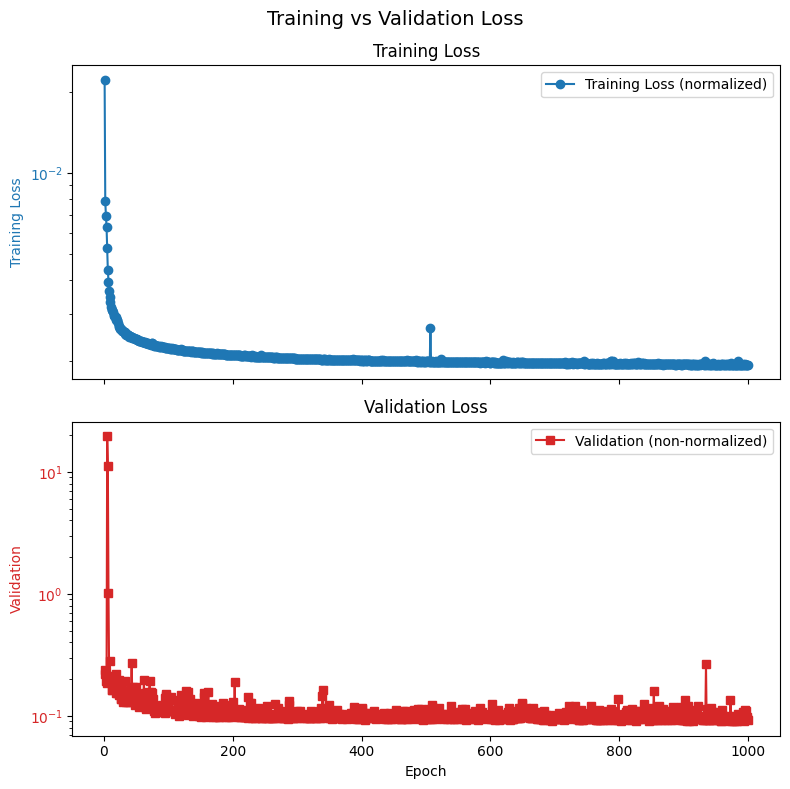

In [14]:
loss_trend = EXPERIMENT_LOGS_ROOT / f"{exp_id}/seed_{seed}_loss_trends.parquet"
loss_train_val = pd.read_parquet(loss_trend).to_numpy()

epochs = np.arange(1, len(loss_train_val) + 1)
train_loss = loss_train_val[:, 0]
val_loss = loss_train_val[:, 1]

# Figure mit zwei Subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Training Loss Plot
axes[0].plot(epochs, train_loss, color="tab:blue", marker="o", label="Training Loss (normalized)")
axes[0].set_ylabel("Training Loss", color="tab:blue")
axes[0].tick_params(axis="y", labelcolor="tab:blue")
axes[0].legend(loc="upper right")
axes[0].set_title("Training Loss")
axes[0].set_yscale("log")

# Validation Loss Plot
axes[1].plot(epochs, val_loss, color="tab:red", marker="s", label="Validation (non-normalized)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation", color="tab:red")
axes[1].tick_params(axis="y", labelcolor="tab:red")
axes[1].legend(loc="upper right")
axes[1].set_title("Validation Loss")
axes[1].set_yscale("log")
# Layout und Anzeige
fig.suptitle("Training vs Validation Loss", fontsize=14)
plt.tight_layout()
plt.show()

In [15]:
# from mc2.features.features_jax import compute_fe_single
# def featurize(norm_B_past, norm_H_past, norm_B_future, temperature):
#         past_length = norm_B_past.shape[0]
#         future_length = norm_B_future.shape[0]

#         featurized_B = compute_fe_single(jnp.hstack([norm_B_past, norm_B_future]), n_s=10)

#         return featurized_B[past_length:]

# normalizer, data_tuple = get_normalizer(
#     "3C90",
#     featurize,
#     1,
#     True,
# )

## Pretest

In [28]:
from mc2.features.features_jax import compute_fe_single
def featurize(norm_B_past, norm_H_past, norm_B_future, temperature):
        past_length = norm_B_past.shape[0]
        future_length = norm_B_future.shape[0]

        featurized_B = compute_fe_single(jnp.hstack([norm_B_past, norm_B_future]), n_s=10)

        return featurized_B[past_length:]

normalizer, data_tuple = get_normalizer(
    "3C90",
    featurize,
    1,
    True,
)

Loading data for 3C90:   0%|          | 0/21 [00:00<?, ?it/s]

Loading data for 3C90: 100%|██████████| 21/21 [00:05<00:00,  3.54it/s]


In [29]:
# seed = 0
# #exp_id = "3C90_8c804f77"#"3C90_78f120d2"
# #exp_id ="3C90_7632996d-4c4c-40"#(RMS-GRU8)#"3C90_4d5b2cc1-4e08-46"#"3C90_5cf07234-fbc2-44" #(RMS-JA+GRu 10epoche) # ##(MSE-GRU8)#
# exp_id_ja = "3C90_4ec8f810-298b-49"# (JA-150-new2)
# #exp_id = "3C90_0a78ff01-c96b-4d" #(JA-WITH-GRU8-100)
# exp_id_gru = "3C90_e872d115-8497-4e"#"3C90_b908af2d-7a65-41" 
# #exp_id_ja_w_ext_gru = "3C90_524bba60-0d7e-47" # (JAWithExternGRU-500-new2)
# exp_id_ja_w_ext_gru = "3C90_af7dbb52-ecab-4b"#"3C90_68d6facc-9e57-4b"#"3C90_35cbeab0-b592-46" #(JAWithExternGRU-500-new2)
# #exp_id_ja_w_gru = "3C90_3be24d39-018c-4d" # (JAWithGRUlin)
# exp_id_ja_w_gru_lin = "3C90_50ef802d-7ccc-4c" # (JAWithGRUlin-750-new2)
# exp_id_param_mlp = "3C90_588a856c-2134-49"
# exp_id_param_gru_lin = "3C90_1519b7ac-ef06-4c" # (JAParamGRUlin-500)
# #exp_id = "3C90_1c1af93c-e010-4a" #(JAGRU-100)
# #exp_id = "3C90_e7266ae8-99a8-42" #(JA2-25)
# #exp_id_jagru = "3C90_c78a3d43-ce9e-46" #(JAGRUlin-100)
# #exp_id_ja2 = "3C90_a4e69149-1e9f-4d" #(JA2-100)
#exp_id = "3C90_8c804f77"#"3C90_78f120d2"
#exp_id ="3C90_7632996d-4c4c-40"#(RMS-GRU8)#"3C90_4d5b2cc1-4e08-46"#"3C90_5cf07234-fbc2-44" #(RMS-JA+GRu 10epoche) # ##(MSE-GRU8)#
exp_id_ja = "3C90_4ec8f810-298b-49"# (JA-150-new2)
#exp_id = "3C90_0a78ff01-c96b-4d" #(JA-WITH-GRU8-100)
#exp_id_gru = "3C90_e872d115-8497-4e"#"3C90_b908af2d-7a65-41" 
exp_id_gru_64 = "3C90_374086cf-c35e-44"#(GRU- 1000 -t 64)
exp_id_gru_128 = "3C90_3518af4e-4e09-42"#(GRU- 1000 -t 128)"3C90_e872d115-8497-4e"#(GRU- 500 -t 128) #"3C90_b908af2d-7a65-41" 
exp_id_gru_256 = "3C90_2df43a32-dd32-4b"#(GRU- 750 -t 256) #"3C90_ff01bbb9-9cbf-44"#(GRU- 2000 -t 256)
exp_id_gru_512 = "3C90_058d5c98-bf0b-4c"#(GRU- 750 -t 512)
exp_id_gru_128_l2 = "3C90_bb0ba4f2-3c5d-42" # (GRU -100 -t 128 loss2)
#exp_id_ja_w_ext_gru = "3C90_524bba60-0d7e-47" # (JAWithExternGRU-500-new2)
exp_id_ja_w_ext_gru = "3C90_af7dbb52-ecab-4b"#"3C90_68d6facc-9e57-4b"#"3C90_35cbeab0-b592-46" #(JAWithExternGRU-500-new2)
#exp_id_ja_w_gru = "3C90_3be24d39-018c-4d" # (JAWithGRUlin)
exp_id_ja_w_gru_lin = "3C90_50ef802d-7ccc-4c" # (JAWithGRUlin-750-new2)
exp_id_param_mlp = "3C90_77b93f91-6624-45"#(JAParamMLP-750 -t 64) #"3C90_588a856c-2134-49"
exp_id_param_gru_lin = "3C90_50565649-6028-44" #(JaParamGRUlin-500 -t 128)#"3C90_1519b7ac-ef06-4c" # (JAParamGRUlin-500)
exp_id_gru_ja = "3C90_cb66532d-ee29-4e" #(GRUWithJA -1000 -t 128)

In [30]:
from functools import partial

#JilesAthertonGRU_part = partial(JilesAthertonGRU, normalizer=normalizer)
# loaded_model=load_model(MODEL_DUMP_ROOT/f"{exp_id_jagru[5:]}.eqx",JilesAthertonGRU_part) # GRU ,JilesAthertonStatic,JilesAthertonGRU_part
# wrappend_model_ja_gru = JAGRUwInterface(loaded_model, normalizer,featurize) #RNNwInterface, JAwInterface,JAGRUwInterface
loaded_model=load_model(MODEL_DUMP_ROOT/f"{exp_id_gru_64[5:]}.eqx",GRU) # GRU ,JilesAthertonStatic,JilesAthertonGRU_part
wrappend_model_gru64 = RNNwInterface(loaded_model, normalizer,featurize) #RNNwInterface, JAwInterface,JAGRUwInterface

loaded_model=load_model(MODEL_DUMP_ROOT/f"{exp_id_gru_128[5:]}.eqx",GRU) # GRU ,JilesAthertonStatic,JilesAthertonGRU_part
wrappend_model_gru128 = RNNwInterface(loaded_model, normalizer,featurize) #RNNwInterface, JAwInterface,JAGRUwInterface

loaded_model=load_model(MODEL_DUMP_ROOT/f"{exp_id_gru_256[5:]}.eqx",GRU) # GRU ,JilesAthertonStatic,JilesAthertonGRU_part
wrappend_model_gru256 = RNNwInterface(loaded_model, normalizer,featurize) #RNNwInterface, JAwInterface,JAGRUwInterface

loaded_model=load_model(MODEL_DUMP_ROOT/f"{exp_id_gru_512[5:]}.eqx",GRU) # GRU ,JilesAthertonStatic,JilesAthertonGRU_part
wrappend_model_gru512 = RNNwInterface(loaded_model, normalizer,featurize) #RNNwInterface, JAwInterface,JAGRUwInterface


loaded_model=load_model(MODEL_DUMP_ROOT/f"{exp_id_gru_128_l2[5:]}.eqx",GRU) # GRU ,JilesAthertonStatic,JilesAthertonGRU_part
wrappend_model_gru128_l2 = RNNwInterface(loaded_model, normalizer,featurize) #RNNwInterface, JAwInterface,JAGRUwInterface

loaded_model=load_model(MODEL_DUMP_ROOT/f"{exp_id_ja[5:]}.eqx",JAStatic) # GRU ,JilesAthertonStatic,JilesAthertonGRU_part
wrappend_model_ja = JAwInterface(loaded_model, normalizer,featurize) #RNNwInterface, JAwInterface,JAGRUwInterface


loaded_model=load_model(MODEL_DUMP_ROOT/f"{exp_id_ja_w_ext_gru[5:]}.eqx",JAWithExternGRU) # GRU ,JilesAthertonStatic,JilesAthertonGRU_part
wrappend_model_ja_w_ext_gru = JAWithExternGRUwInterface(loaded_model, normalizer,featurize) #RNNwInterface, JAwInterface,JAGRUwInterface

JAParamMLP_part = partial(JAParamMLP, normalizer=normalizer)
loaded_model=load_model(MODEL_DUMP_ROOT/f"{exp_id_param_mlp[5:]}.eqx",JAParamMLP_part)
wrappend_model_ja_param_mlp = JAParamMLPwInterface(loaded_model, normalizer,featurize)

JAWithGRUlin_part = partial(JAWithGRUlin, normalizer=normalizer)
loaded_model=load_model(MODEL_DUMP_ROOT/f"{exp_id_ja_w_gru_lin[5:]}.eqx",JAWithGRUlin_part) # GRU ,JilesAthertonStatic,JilesAthertonGRU_part
wrappend_model_ja_w_gru_lin = JAWithGRUwInterface(loaded_model, normalizer,featurize)

GRUWithJA_part = partial(GRUWithJA, normalizer=normalizer)
loaded_model=load_model(MODEL_DUMP_ROOT/f"{exp_id_gru_ja[5:]}.eqx",GRUWithJA_part) # GRU ,JilesAthertonStatic,JilesAthertonGRU_part
wrappend_model_gru_w_ja = GRUWithJAwInterface(loaded_model, normalizer,featurize)
# JAParamGRUlin_part = partial(JAParamGRUlin, normalizer=normalizer)
# loaded_model=load_model(MODEL_DUMP_ROOT/f"{exp_id_param_gru_lin[5:]}.eqx",JAParamGRUlin_part)
# wrappend_model_ja_param_gru_lin = JAWithGRUwInterface(loaded_model, normalizer,featurize)

/home/oliverjs@uni-paderborn.de/mc_2/magnet-challenge-2/mc2/models/model_interface.py:248: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = model_class(key=jax.random.PRNGKey(0), **hyperparams)


In [31]:
# jagru = JilesAthertonGRU(hidden_size=8,normalizer=normalizer,in_size=7,key=jax.random.PRNGKey(123))
# wrappend_model_ja_gru = JAGRUwInterface(jagru, normalizer,featurize)

# ja = JilesAthertonStatic(key=jax.random.PRNGKey(123))
# wrappend_model_ja = JAwInterface(ja, normalizer,featurize)

# jaWgru = JilesAthertonWithGRU(hidden_size=8,in_size=7,key=jax.random.PRNGKey(123))
# wrappend_model_ja_gru = JAwGRUwInterface(jaWgru, normalizer,featurize)

In [32]:
from IPython.display import display, HTML
def create_multilevel_df(nested_dict):
    """Convert 3-level nested dict to DataFrame with outer keys as index and 2-level columns"""
    dfs_by_model = []
    for model_name, model_metrics in nested_dict.items():
        # Create tuples for MultiIndex columns (scenario, metric)
        tuples = [(scenario, metric) for scenario in model_metrics.keys() for metric in model_metrics[scenario].keys()]
        values = [model_metrics[scenario][metric] for scenario in model_metrics.keys() for metric in model_metrics[scenario].keys()]
        
        # Create DataFrame for this model
        df_model = pd.DataFrame([values], columns=pd.MultiIndex.from_tuples(tuples), index=[model_name])
        dfs_by_model.append(df_model)
    
    # Concatenate and set column names
    df = pd.concat(dfs_by_model, axis=0)
    #df.columns.names = ['Scenario', 'Metric']
    return df

In [33]:
mat = "3C90"
B, T, H_init, H_true, loss, loss_short, msks_scenarios_N_tup = load_hdf5_pretest_data(mat)
B.shape, T.shape, H_init.shape, H_true.shape

Scenario counts: [2100 2100 2100]


((6300, 1000), (6300, 1), (6300, 1000), (6300, 1000))

In [34]:
scenario_labels = ["10% unknown", "50% unknown", "90% unknown"]

def evaluate_pretest_scenarios_custom(
    model_all, B, T, H_init, H_true, loss, msks_scenarios_N_tup, show_plots: bool = False
):
    """
    Evaluates the given model on pretest scenarios with different amounts of unknown samples.
    Works with batched NumPy inputs (model_all takes arrays of shape (batch, time)).
    """

    metrics_d = {}

    for scenario_i, msk_N in enumerate(msks_scenarios_N_tup):
        print(f"  Scenario {scenario_i} - {scenario_labels[scenario_i]}: ")

        B_scenario = B[msk_N]
        T_scenario = T[msk_N]
        H_init_scenario = H_init[msk_N]
        H_true_scenario = H_true[msk_N]

        warm_up_len = np.sum(~np.isnan(H_init_scenario[0]))
        print(warm_up_len/B_scenario.shape[1])
        print(f"    -> warm_up_len = {warm_up_len}")


        B_past = B_scenario[:, :warm_up_len]
        H_past = H_init_scenario[:, :warm_up_len]
        B_future = B_scenario[:, warm_up_len:]
        T_batch = T_scenario.reshape(-1) 

        # preds = model_all(
        #     B_past=B_past,
        #     H_past=H_past,
        #     B_future=B_future,
        #     T=T_batch,
        # ) 
        preds = model_all.call_with_warmup(
            B_past=B_past,
            H_past=H_past,
            B_future=B_future,
            T=T_batch,
        ) 

        H_gt = H_true_scenario[:, warm_up_len:]

        # ---- metrics ----
        wce_per_sequence = np.max(np.abs(preds - H_gt), axis=1)
        mse_per_sequence = np.mean((preds - H_gt) ** 2, axis=1)

        mse = np.mean(mse_per_sequence)
        wce = np.max(np.abs(preds - H_gt))
        sre_per_sequence = np.sqrt(mse_per_sequence) / np.sqrt(np.mean(H_gt**2, axis=1))
        sre_avg = np.mean(sre_per_sequence)
        sre_95th = np.percentile(sre_per_sequence, 95)

        dbdt_full = np.gradient(B_scenario, axis=1)
        dbdt = dbdt_full[:, warm_up_len:]
        nere_per_sequence = np.abs((((dbdt * preds) - (dbdt * H_gt)).sum(axis=1)) / np.abs(loss[msk_N][:,0])) #added abs
        nere_avg = np.mean(nere_per_sequence)
        nere_95th = np.percentile(nere_per_sequence, 95)

        print(f"\tMSE : {mse:>7.2f} (A/m)²")
        print(f"\tWCE : {wce:>7.2f} A/m")

        metrics_d[scenario_labels[scenario_i]] = {
            "mse": np.round(mse, 3).item(),
            "wce": np.round(wce, 3).item(),
            "sre_avg": np.round(sre_avg, 3).item(),
            "sre_95th": np.round(sre_95th, 3).item(),
            "nere_avg": np.round(nere_avg, 3).item(),
            "nere_95th": np.round(nere_95th, 3).item(),
        }

        # optional plots
        if show_plots:
            n_plots = min(5, preds.shape[0])
            idx_argmax = np.argpartition(wce_per_sequence, -n_plots)[-n_plots:]

            fig, axes = plt.subplots(n_plots, 1, sharex=True, figsize=(10, 2.5 * n_plots))
            if n_plots == 1:
                axes = [axes]
            for j, idx in enumerate(idx_argmax):
                ax = axes[j]
                ax.plot(H_gt[idx], label="gt")
                ax.plot(preds[idx], label="pred", ls="dashed")
                ax.annotate(
                    f"MSE {mse_per_sequence[idx]:.1f} (A/m)² | WCE {wce_per_sequence[idx]:.1f} A/m",
                    (0.3, 0.1), xycoords=ax.transAxes
                )
                ax.grid(alpha=0.3)
                ax.set_ylabel("H in A/m")
            axes[0].set_title(f"Worst-case predictions - {scenario_labels[scenario_i]}")
            axes[-1].set_xlabel("Sequence step")
            axes[0].legend()
            fig.tight_layout()

    return metrics_d


In [35]:
# metrics_model_ja_gru = evaluate_pretest_scenarios_custom(wrappend_model_ja_w_gru_lin,B, T, H_init, H_true, loss, msks_scenarios_N_tup,True)

  Scenario 0 - 10% unknown: 
0.9
    -> warm_up_len = 900
	MSE :    5.01 (A/m)²
	WCE :   99.04 A/m
  Scenario 1 - 50% unknown: 
0.5
    -> warm_up_len = 500
	MSE :   28.57 (A/m)²
	WCE :  288.54 A/m
  Scenario 2 - 90% unknown: 
0.1
    -> warm_up_len = 100
	MSE :   23.82 (A/m)²
	WCE :  260.49 A/m


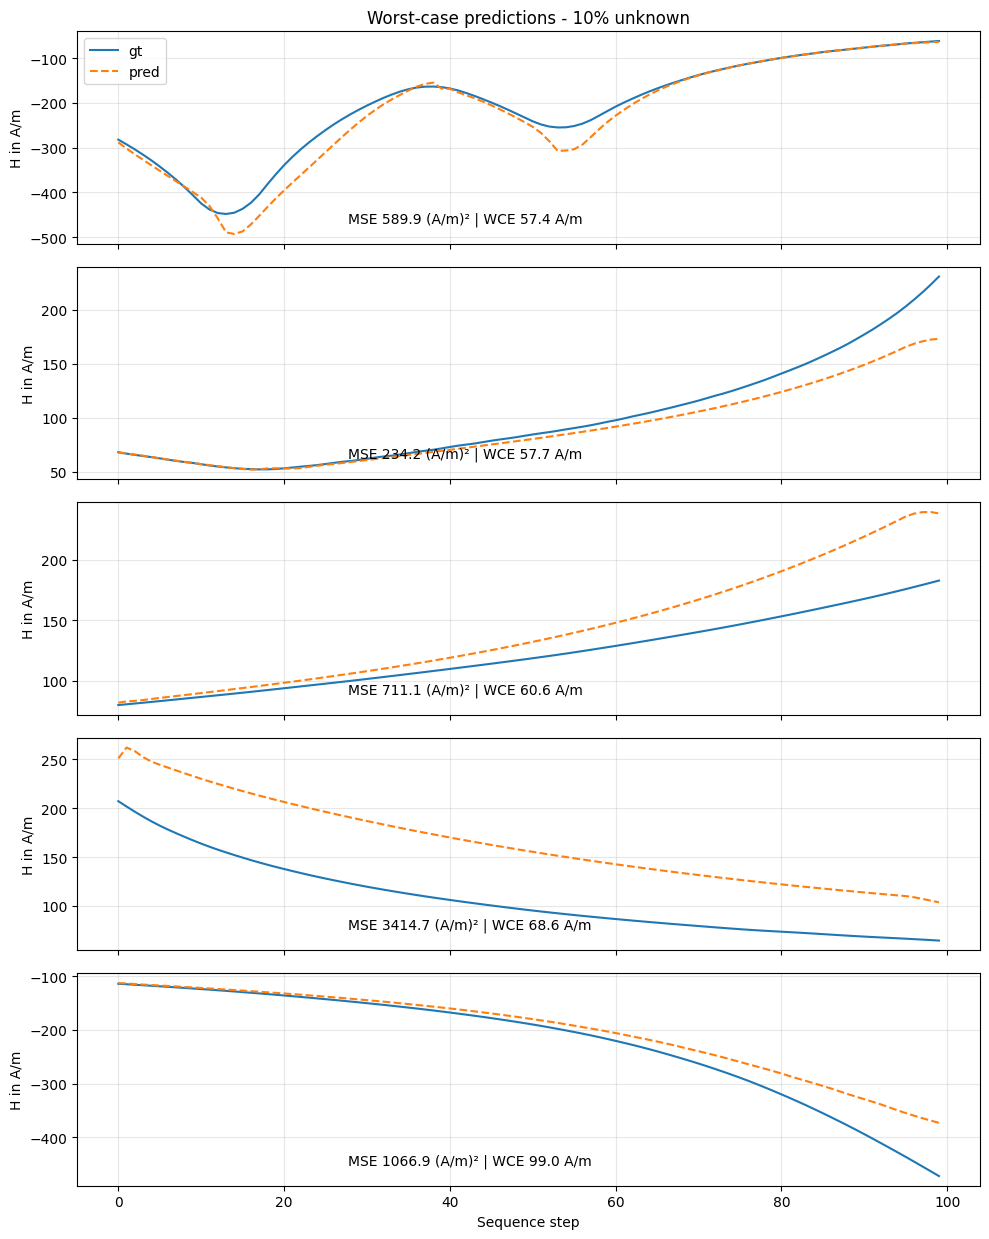

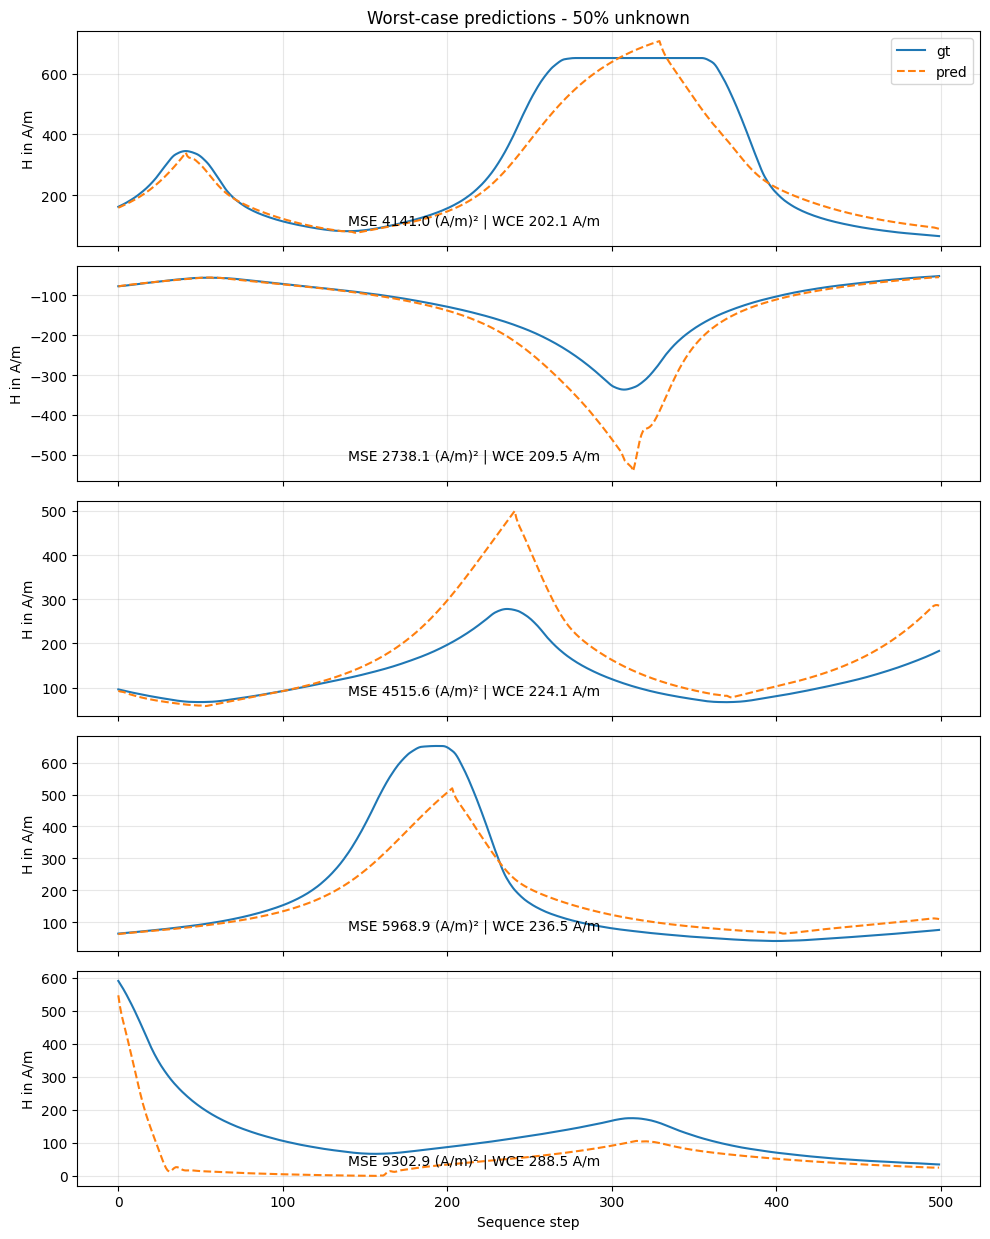

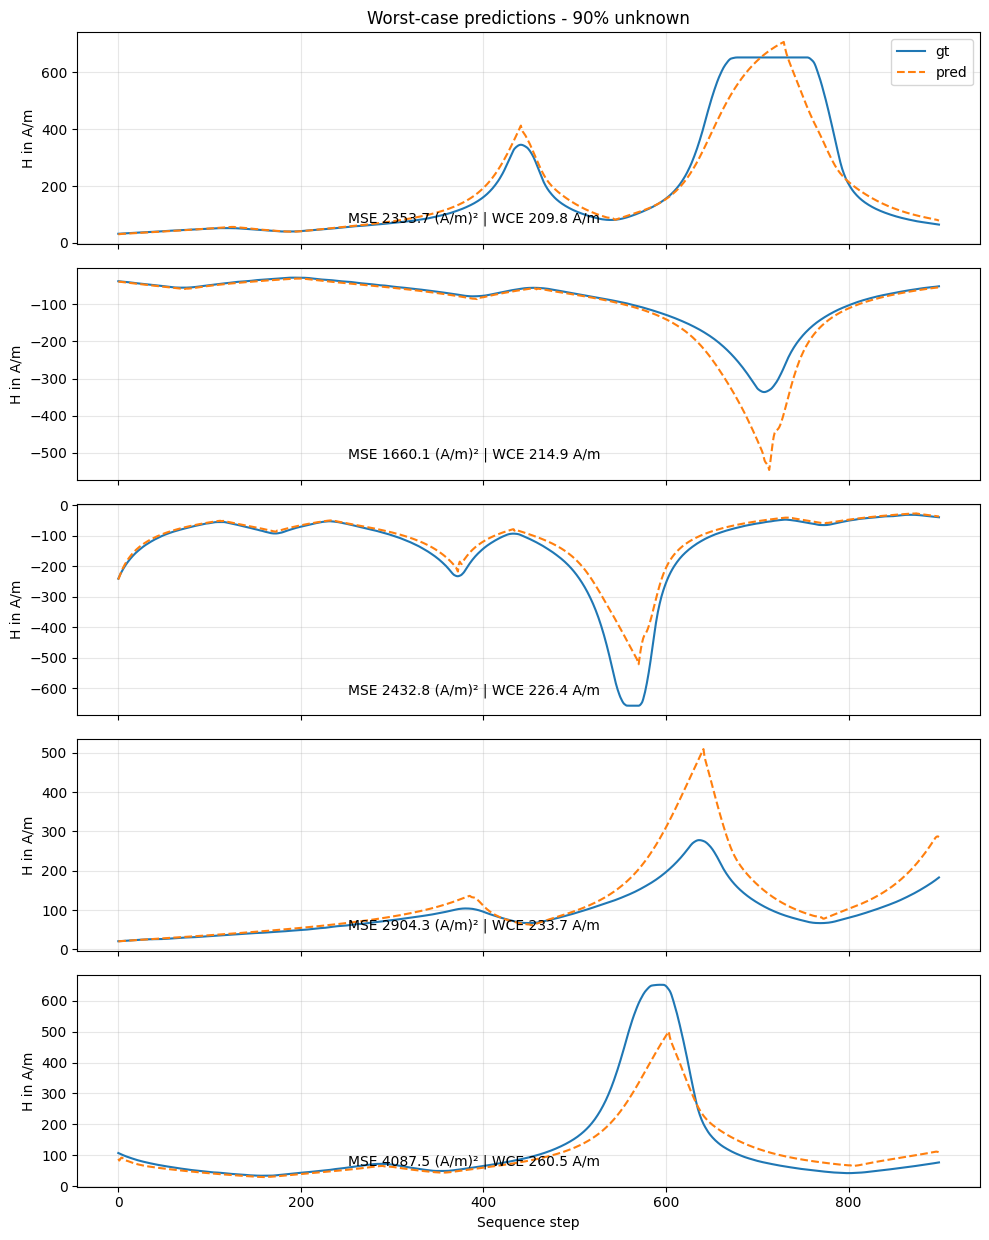

In [36]:
metrics_model_ja_w_gru_lin = evaluate_pretest_scenarios_custom(wrappend_model_ja_w_gru_lin,B, T, H_init, H_true, loss, msks_scenarios_N_tup,True)

In [37]:
metrics_model_ja = evaluate_pretest_scenarios_custom(wrappend_model_ja,B, T, H_init, H_true, loss, msks_scenarios_N_tup,False)
metrics_model_ja_w_gru_lin = evaluate_pretest_scenarios_custom(wrappend_model_ja_w_gru_lin,B, T, H_init, H_true, loss, msks_scenarios_N_tup,False)
metrics_model_ja_w_ext_gru = evaluate_pretest_scenarios_custom(wrappend_model_ja_w_ext_gru,B, T, H_init, H_true, loss, msks_scenarios_N_tup,False)
metrics_model_gru64 = evaluate_pretest_scenarios_custom(wrappend_model_gru64,B, T, H_init, H_true, loss, msks_scenarios_N_tup,False)
metrics_model_gru128 = evaluate_pretest_scenarios_custom(wrappend_model_gru128,B, T, H_init, H_true, loss, msks_scenarios_N_tup,False)
metrics_model_gru256 = evaluate_pretest_scenarios_custom(wrappend_model_gru256,B, T, H_init, H_true, loss, msks_scenarios_N_tup,False)
metrics_model_gru512 = evaluate_pretest_scenarios_custom(wrappend_model_gru512,B, T, H_init, H_true, loss, msks_scenarios_N_tup,False)
metrics_model_gru128_l2 = evaluate_pretest_scenarios_custom(wrappend_model_gru128_l2,B, T, H_init, H_true, loss, msks_scenarios_N_tup,False)
metrics_model_ja_param_mlp = evaluate_pretest_scenarios_custom(wrappend_model_ja_param_mlp,B, T, H_init, H_true, loss, msks_scenarios_N_tup,False)
metrics_model_gru_w_ja = evaluate_pretest_scenarios_custom(wrappend_model_gru_w_ja,B, T, H_init, H_true, loss, msks_scenarios_N_tup,False)
#metrics_model_ja_param_gru_lin = evaluate_pretest_scenarios_custom(wrappend_model_ja_param_gru_lin,B, T, H_init, H_true, loss, msks_scenarios_N_tup,False)

  Scenario 0 - 10% unknown: 
0.9
    -> warm_up_len = 900
	MSE :   35.73 (A/m)²
	WCE :  345.00 A/m
  Scenario 1 - 50% unknown: 
0.5
    -> warm_up_len = 500
	MSE :  366.09 (A/m)²
	WCE :  547.47 A/m
  Scenario 2 - 90% unknown: 
0.1
    -> warm_up_len = 100
	MSE :  356.49 (A/m)²
	WCE :  550.91 A/m
  Scenario 0 - 10% unknown: 
0.9
    -> warm_up_len = 900
	MSE :    5.01 (A/m)²
	WCE :   99.04 A/m
  Scenario 1 - 50% unknown: 
0.5
    -> warm_up_len = 500
	MSE :   28.57 (A/m)²
	WCE :  288.54 A/m
  Scenario 2 - 90% unknown: 
0.1
    -> warm_up_len = 100
	MSE :   23.82 (A/m)²
	WCE :  260.49 A/m
  Scenario 0 - 10% unknown: 
0.9
    -> warm_up_len = 900
	MSE :    7.94 (A/m)²
	WCE :   83.12 A/m
  Scenario 1 - 50% unknown: 
0.5
    -> warm_up_len = 500
	MSE :  103.04 (A/m)²
	WCE :  482.00 A/m
  Scenario 2 - 90% unknown: 
0.1
    -> warm_up_len = 100
	MSE :   98.14 (A/m)²
	WCE :  520.85 A/m
  Scenario 0 - 10% unknown: 
0.9
    -> warm_up_len = 900
	MSE :    4.39 (A/m)²
	WCE :   86.97 A/m
  Scenario

In [38]:
hosts_d = {"3C90": {scenario_labels[0]: {"mse": None, "wce": None, "sre_avg": 0.1305, "sre_95th": 0.347, "nere_avg": 0.007623, "nere_95th": 0.01928}, # 90 % known
           scenario_labels[1]: {"mse": None, "wce": None, "sre_avg": 0.1602, "sre_95th": 0.3443, "nere_avg": 0.0341, "nere_95th": 0.05603}, # 50 % known
           scenario_labels[2]: {"mse": None, "wce": None, "sre_avg": 0.1704, "sre_95th": 0.3476, "nere_avg": 0.0618, "nere_95th": 0.07476}}, # 10 % known
           "N87": {scenario_labels[0]: {"mse": None, "wce": None, "sre_avg": 0.1962, "sre_95th": 0.521, "nere_avg": 0.007805, "nere_95th": 0.0157}, # 90 % known
           scenario_labels[1]: {"mse": None, "wce": None, "sre_avg": 0.2767, "sre_95th": 0.8498, "nere_avg": 0.02577, "nere_95th": 0.05509}, # 50 % known
           scenario_labels[2]: {"mse": None, "wce": None, "sre_avg": 0.3028, "sre_95th": 0.9999, "nere_avg": 0.04828, "nere_95th": 0.0681} # 10 % known
           }}
all_models_d = {"hosts": hosts_d[mat], "GRU-8 -t 64": metrics_model_gru64, "GRU-8 -t 128": metrics_model_gru128, "GRU-8 -t 256": metrics_model_gru256, "GRU-8 -t 512": metrics_model_gru512,"GRU-8 -t 128 l2": metrics_model_gru128_l2,"JA": metrics_model_ja,"GRUWithJA": metrics_model_gru_w_ja, "JAWithExternGRU-8": metrics_model_ja_w_ext_gru, "JAWithGRU-8+Lin": metrics_model_ja_w_gru_lin, "JAParamMLP-(32,2)": metrics_model_ja_param_mlp} #, "JAParamGRU-8+lin":metrics_model_ja_param_gru_lin ,"JA2": metrics_model_ja2 ,"JAGRUlin": metrics_model_ja_gru 

In [39]:
# 3C90
df_models_3C90 = create_multilevel_df(all_models_d)
display(HTML(df_models_3C90.T.to_html(float_format="%.3f", bold_rows=False)))

/tmp/ipykernel_1216730/586201257.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs_by_model, axis=0)


In [40]:
highlight_col = "GRU-8 -t 128"  
highlight_col_host = "hosts"

def highlight_column(s):
    color_best = 'background-color: #264653'
    color_host = 'background-color: #6d071a'
    df_styled = pd.DataFrame('', index=s.index, columns=s.columns)
    if highlight_col in df_styled.columns:
        df_styled[highlight_col] = color_best
    if highlight_col_host in df_styled.columns:
        df_styled[highlight_col_host] = color_host
    return df_styled

styled = df_models_3C90.T.style.apply(highlight_column, axis=None)
display(styled.format(precision=3))